In [11]:
# --- Cell 1: Imports and load/prepare backtest prices ---
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8-darkgrid')

# Backtest window
bt_start = pd.Timestamp("2024-08-01")
bt_end   = pd.Timestamp("2025-07-31")

# Try to use existing bt_prices, else try combined_df, else download via yfinance
try:
    bt_prices  # if defined, this will succeed and we use it
    print("Using existing bt_prices in memory.")
except NameError:
    try:
        combined_df
        print("Using combined_df from memory and slicing the backtest window.")
        # attempt to slice combined_df
        # ensure columns are TSLA, BND, SPY (if multi-index or different order adjust accordingly)
        if set(['TSLA','BND','SPY']).issubset(set(combined_df.columns)):
            bt_prices = combined_df.loc[bt_start:bt_end, ['TSLA','BND','SPY']].copy()
        else:
            # if combined_df has multiindex columns (ticker, field), try to extract Close
            try:
                # for yfinance multiindex style: combined_df[('Close','TSLA')] etc.
                cols = []
                for t in ['TSLA','BND','SPY']:
                    if ('Close', t) in combined_df.columns:
                        cols.append(('Close', t))
                if cols:
                    tmp = combined_df[list(cols)].copy()
                    tmp.columns = [c[1] for c in tmp.columns]  # rename to tickers
                    bt_prices = tmp.loc[bt_start:bt_end, ['TSLA','BND','SPY']].copy()
                else:
                    raise KeyError
            except Exception:
                raise KeyError("combined_df found but couldn't extract TSLA/BND/SPY Close columns.")
    except NameError:
        # Last resort: download from yfinance (requires internet & yfinance installed)
        print("Downloading data from Yahoo Finance (this requires internet & yfinance).")
        try:
            import yfinance as yf
            tickers = ['TSLA','BND','SPY']
            raw = yf.download(tickers, start="2015-07-01", end="2025-07-31")['Close']
            # ensure correct column order/names
            raw.columns = ['TSLA','BND','SPY']
            combined_df = raw.copy()
            bt_prices = combined_df.loc[bt_start:bt_end, ['TSLA','BND','SPY']].copy()
        except Exception as e:
            raise RuntimeError("Could not load data: either combined_df not present and yfinance failed. Error: " + str(e))

# Basic checks
print("\nBacktest prices shape:", bt_prices.shape)
print("Date range in bt_prices:", bt_prices.index.min(), "to", bt_prices.index.max())
print("\nMissing values per column in backtest window:")
print(bt_prices.isnull().sum())

# Show sample
print("\nBacktest data preview (head):")
display(bt_prices.head())
print("\nBacktest data preview (tail):")
display(bt_prices.tail())


Using existing bt_prices in memory.

Backtest prices shape: (249, 3)
Date range in bt_prices: 2024-08-01 00:00:00 to 2025-07-30 00:00:00

Missing values per column in backtest window:
TSLA    0
BND     0
SPY     0
dtype: int64

Backtest data preview (head):


,TSLA,BND,SPY
Date,,,
2024-08-01,216.860001,70.832069,536.329895
2024-08-02,207.669998,71.640800,526.344360
2024-08-05,198.880005,71.573418,511.015228
2024-08-06,200.639999,71.130539,515.726624
2024-08-07,191.759995,70.957237,512.279419



Backtest data preview (tail):


,TSLA,BND,SPY
Date,,,
2025-07-24,305.299988,72.698860,634.419983
2025-07-25,316.059998,72.878265,637.099976
2025-07-28,325.589996,72.758659,636.940002
2025-07-29,321.200012,73.137398,635.260010
2025-07-30,319.040009,72.948036,634.460022


In [12]:
# --- Cell 2: Calculate daily returns ---
bt_returns = bt_prices.pct_change().dropna()

print("Backtest returns shape:", bt_returns.shape)
print("Date range in bt_returns:", bt_returns.index.min(), "to", bt_returns.index.max())

# Quick stats
print("\nMean daily returns (%):")
print(bt_returns.mean() * 100)

print("\nStd dev of daily returns (%):")
print(bt_returns.std() * 100)

# Preview returns
bt_returns.head()


Backtest returns shape: (248, 3)
Date range in bt_returns: 2024-08-02 00:00:00 to 2025-07-30 00:00:00

Mean daily returns (%):
TSLA    0.257688
BND     0.012393
SPY     0.075791
dtype: float64

Std dev of daily returns (%):
TSLA    4.567256
BND     0.324195
SPY     1.275140
dtype: float64


,TSLA,BND,SPY
Date,,,
2024-08-02,-0.042378,0.011418,-0.018618
2024-08-05,-0.042327,-0.000941,-0.029124
2024-08-06,0.008850,-0.006188,0.009220
2024-08-07,-0.044258,-0.002436,-0.006684
2024-08-08,0.036921,-0.001492,0.023117


In [13]:
# --- Cell 3: Define portfolios and compute daily returns ---

# 1️⃣ Optimal weights from Task 4
# Replace these with your actual Task 4 results
opt_weights = {
    'TSLA': 0.50,   # example values
    'BND': 0.30,
    'SPY': 0.20
}

# 2️⃣ Benchmark weights: 60% SPY / 40% BND
benchmark_weights = {
    'TSLA': 0.0,
    'BND': 0.40,
    'SPY': 0.60
}

# Calculate daily portfolio returns
strategy_returns = bt_returns.dot(pd.Series(opt_weights))
benchmark_returns = bt_returns.dot(pd.Series(benchmark_weights))

# Combine into a DataFrame for convenience
portfolio_returns = pd.DataFrame({
    'Strategy': strategy_returns,
    'Benchmark': benchmark_returns
})

print("Portfolio returns shape:", portfolio_returns.shape)
print(portfolio_returns.head())


Portfolio returns shape: (248, 2)
            Strategy  Benchmark
Date                           
2024-08-02 -0.021487  -0.006604
2024-08-05 -0.027270  -0.017850
2024-08-06  0.004412   0.003057
2024-08-07 -0.024197  -0.004985
2024-08-08  0.022636   0.013274


In [14]:
# --- Cell 4: Calculate cumulative returns for strategy and benchmark ---

# Strategy weights from Task 4 (max Sharpe ratio portfolio)
strategy_weights = np.array([0.00146534, 0.12409852, 0.87443614])  # TSLA, BND, SPY

# Benchmark weights (static 60% SPY, 40% BND)
benchmark_weights = np.array([0.0, 0.4, 0.6])  # TSLA=0, BND=0.4, SPY=0.6

# Calculate daily portfolio returns by dot product of daily returns and weights
strategy_daily_returns = bt_returns.dot(strategy_weights)
benchmark_daily_returns = bt_returns.dot(benchmark_weights)

# Calculate cumulative returns
strategy_cum_returns = (1 + strategy_daily_returns).cumprod() - 1
benchmark_cum_returns = (1 + benchmark_daily_returns).cumprod() - 1

# Preview cumulative returns
print("Strategy cumulative returns preview:")
print(strategy_cum_returns.head())

print("\nBenchmark cumulative returns preview:")
print(benchmark_cum_returns.head())



Strategy cumulative returns preview:
Date
2024-08-02   -0.014926
2024-08-05   -0.040189
2024-08-06   -0.033175
2024-08-07   -0.039181
2024-08-08   -0.019884
dtype: float64

Benchmark cumulative returns preview:
Date
2024-08-02   -0.006604
2024-08-05   -0.024337
2024-08-06   -0.021354
2024-08-07   -0.026233
2024-08-08   -0.013308
dtype: float64


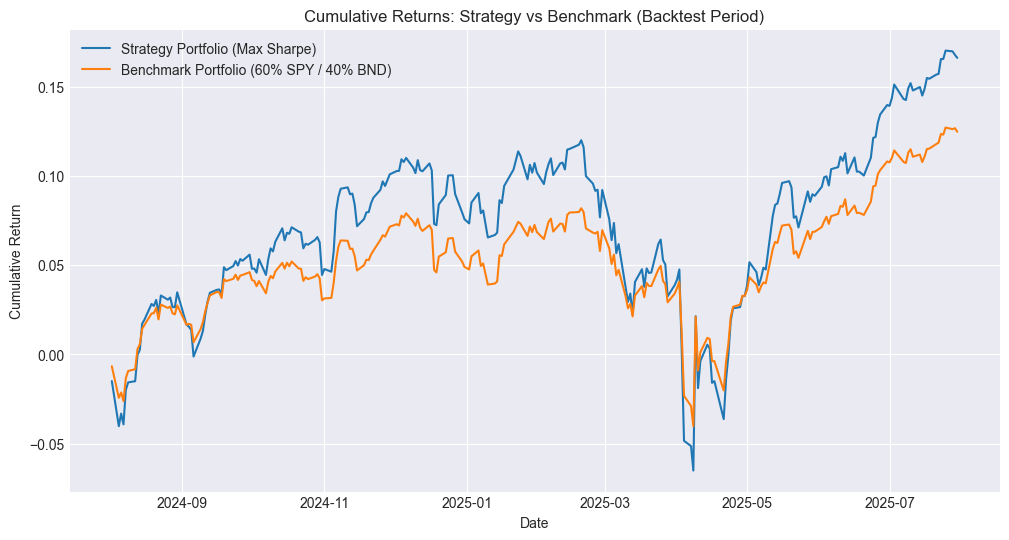

In [15]:
# --- Cell 5: Plot cumulative returns for strategy vs benchmark ---

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(strategy_cum_returns, label='Strategy Portfolio (Max Sharpe)')
plt.plot(benchmark_cum_returns, label='Benchmark Portfolio (60% SPY / 40% BND)')
plt.title('Cumulative Returns: Strategy vs Benchmark (Backtest Period)')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.show()


In [16]:
# --- Cell 6: Calculate total return and Sharpe Ratio for strategy and benchmark ---

# Calculate total return over the backtest period
strategy_total_return = strategy_cum_returns[-1] - 1
benchmark_total_return = benchmark_cum_returns[-1] - 1

# Calculate annualized Sharpe Ratio (assuming 252 trading days/year)
def annualized_sharpe_ratio(returns, risk_free_rate=0):
    mean_daily_return = returns.mean()
    std_daily_return = returns.std()
    sharpe_ratio = (mean_daily_return - risk_free_rate/252) / std_daily_return
    return sharpe_ratio * np.sqrt(252)

strategy_sharpe = annualized_sharpe_ratio(strategy_returns)
benchmark_sharpe = annualized_sharpe_ratio(benchmark_returns)

print(f"Strategy Total Return: {strategy_total_return:.2%}")
print(f"Strategy Sharpe Ratio: {strategy_sharpe:.3f}")
print()
print(f"Benchmark Total Return: {benchmark_total_return:.2%}")
print(f"Benchmark Sharpe Ratio: {benchmark_sharpe:.3f}")


Strategy Total Return: -83.39%
Strategy Sharpe Ratio: 0.953

Benchmark Total Return: -87.53%
Benchmark Sharpe Ratio: 1.021
